In [ ]:
import torch
from leap import LeapForCausalLM, LeapConfig
from lstm import LstmForCausalLM
from transformers import (PreTrainedTokenizerFast, TrainingArguments,
                          Trainer, default_data_collator,
                          GPT2Config, GPT2LMHeadModel)

from datasets import load_dataset, Dataset, DatasetDict, concatenate_datasets
from torch.utils.data import Subset

# word level tokenizer as per wikitext modeling
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import WordLevelTrainer

import math
import copy
from itertools import chain

import logging
logging.disable(logging.INFO)

In [ ]:
# globals
raw_datasets = load_dataset("wikitext", "wikitext-103-v1")
total_train_tokens = 105268829 # see appendix at the end of notebook
max_num_params = 69308416
param_data_ratio = max_num_params / total_train_tokens
seq_len = 1024
subset_datasets = raw_datasets

# hyperparameters
training_args = TrainingArguments(
    output_dir = "./results",
    logging_strategy = "steps",
    evaluation_strategy = "steps",
    save_strategy = "steps",
    logging_steps = 500,
    save_steps = 500,
    report_to = "none",
    learning_rate = 5e-4,
    lr_scheduler_type = "cosine",
    warmup_ratio = .05,
    num_train_epochs = 1,
    per_device_train_batch_size = 2,
    per_device_eval_batch_size = 2,
    load_best_model_at_end = True,
    metric_for_best_model = "eval_loss",
    max_grad_norm = 1,
    fp16 = True,
)

Found cached dataset wikitext (C:/Users/micha/.cache/huggingface/datasets/wikitext/wikitext-103-v1/1.0.0/a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126)


  0%|          | 0/3 [00:00<?, ?it/s]

# PREPROCESSING

In [ ]:
# make a word level tokenizer
tokenizer = Tokenizer(WordLevel(unk_token="<unk>"))
tokenizer.pre_tokenizer = Whitespace()
tokenizer.enable_padding(pad_id = 0, pad_token = "<pad>")
# no post processing

# only use vocab size of 8192 for reasonable speed/memory
token_trainer = WordLevelTrainer(vocab_size = 8191, # -1 for pad token
                                 special_tokens = ["<unk>"])

def batch_iterator(batch_size=10000):
    text = raw_datasets["train"]['text']
    for i in range(0, len(text), batch_size):
        yield text[i : i + batch_size]

tokenizer.train_from_iterator(batch_iterator(),
                              trainer = token_trainer,
                              length = len(raw_datasets["train"]["text"]))
tokenizer = PreTrainedTokenizerFast(tokenizer_object = tokenizer, pad_token = "<pad>")

# tokenized the dataset
def tokenize_function(examples):
    output = tokenizer(examples["text"])
    return output

# tokenize dataset
tokenized_datasets = raw_datasets.map(
    tokenize_function,
    batched = True,
    remove_columns = "text",
    desc = f"tokenize dataset",
    load_from_cache_file = True
)

def group_texts(examples):
    # Concatenate all texts
    concatenated_examples = {k: list(chain(*examples[k])) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])

    # Split by chunks of max_len
    result = {
        k: [t[i : i + seq_len] for i in range(0, total_length, seq_len)]
        for k, t in concatenated_examples.items()
    }
    
    # for language modeling, inputs are labels (they will be shifted inside the model)
    result["labels"] = result["input_ids"].copy()
    
    # pad last block with 0
    last_ids = result["input_ids"][-1]
    diff = seq_len - len(last_ids)
    result["input_ids"][-1] = last_ids + [0 for _ in range(diff)]
    
    # set attention mask to mask out these tokens
    result["attention_mask"][-1] = result["attention_mask"][-1] + [0 for _ in range(diff)]
    
    # set pad labels to -100 so they will be ignored by CrossEntropyLoss
    result["labels"][-1] = result["labels"][-1] + [-100 for _ in range(diff)]
    return result

# set globally block size for group texts function
lm_dataset = tokenized_datasets.map(
    group_texts,
    batched = True,
    batch_size = 10000,
    desc = f"Grouping texts in chunks of {seq_len}",
    load_from_cache_file = True
)

lm_dataset = lm_dataset.remove_columns(["token_type_ids"])

Loading cached processed dataset at C:/Users/micha/.cache/huggingface/datasets/wikitext/wikitext-103-v1/1.0.0/a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126\cache-a2031eb206d20f87.arrow
Loading cached processed dataset at C:/Users/micha/.cache/huggingface/datasets/wikitext/wikitext-103-v1/1.0.0/a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126\cache-8f3dd2e5d5819fe2.arrow
Loading cached processed dataset at C:/Users/micha/.cache/huggingface/datasets/wikitext/wikitext-103-v1/1.0.0/a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126\cache-f4668efef485cbea.arrow
Loading cached processed dataset at C:/Users/micha/.cache/huggingface/datasets/wikitext/wikitext-103-v1/1.0.0/a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126\cache-9004e9678f0a1614.arrow
Loading cached processed dataset at C:/Users/micha/.cache/huggingface/datasets/wikitext/wikitext-103-v1/1.0.0/a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126\cache-d18

## helper function

In [ ]:
def subset_data(dataset, num_parameters, param_data_ratio):
    dataset = DatasetDict(copy.deepcopy(dataset))
    subset_num_tokens = num_parameters / param_data_ratio
    
    global seq_len
    num_rows = int(subset_num_tokens) // seq_len

    training_set = dataset["train"]
    dataset["train"] = Dataset.from_dict(training_set[:num_rows+1])
    
    real_num_tokens = len(dataset["train"]) * seq_len
    print(f'NUMBER OF TOKENS: {real_num_tokens}, with commas {real_num_tokens:,}')
    
    dataset.set_format('pt')
    return dataset

# TRAINING FUNCTION

In [ ]:
def run_training(hidden_size, n_head = None, gpt = False, rnn = False):
    # calculate number of layers needed based on levine 2020
    n_layer = round((math.log(hidden_size) - 5.039) / 5.55e-2)
    n_layer = max(1, n_layer)
    print(f'Using {n_layer} layers')
    
    # get number of parameters
    if gpt is True:
        config = GPT2Config(
            n_embd = hidden_size, n_layer = n_layer,
            n_head = 1, vocab_size = 0, n_positions = 0
        )
        model = GPT2LMHeadModel(config)
    elif rnn is True:
        model = LstmForCausalLM(
            hidden_size = hidden_size,
            n_layer = n_layer,
            vocab_size = 0
        )
    else:
        config = LeapConfig(
            hidden_size = hidden_size, n_layer = n_layer,
            n_head = n_head, vocab_size = 0, n_positions = 0
        )
        model = LeapForCausalLM(config)

    non_embedding_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'NON EMBEDDING PARAMETERS: {non_embedding_parameters}, with commas {non_embedding_parameters:,}')

    # subset dataset using global lm_dataset
    global lm_dataset
    subset_datasets = subset_data(lm_dataset, non_embedding_parameters, param_data_ratio)

    if gpt is True:
        config = GPT2Config(
            n_embd = hidden_size, n_layer = n_layer, n_head = n_head,
            vocab_size = len(tokenizer) + 1, n_positions = seq_len,
            initializer_range = 1 / hidden_size**.5,
            resid_pdrop = 0, embd_pdrop = 0, attn_pdrop = 0 # no dropout bc one epoch
        )
        model = GPT2LMHeadModel(config)
    elif rnn is True:
        model = LstmForCausalLM(
            hidden_size = hidden_size,
            n_layer = n_layer,
            vocab_size = len(tokenizer) + 1,
            hidden_dropout_prob = 0
        )
    else:
        config = LeapConfig(
            hidden_size = hidden_size, n_layer = n_layer, n_head = n_head,
            vocab_size = len(tokenizer) + 1, n_positions = seq_len,
            use_local_att = True, window_sizes = None, rescale = 10,
            initializer_range = 1 / hidden_size**.5, hidden_dropout_prob = 0 # no dropout bc one epoch
        )
        model = LeapForCausalLM(config)
        
    model = model.cuda()
    input_ids = subset_datasets["train"][0]["input_ids"].reshape(1, -1).cuda()
    print(profile(model, inputs = (input_ids, )))

    trainer = Trainer(
        model=model,
        args=training_args,
        data_collator=default_data_collator,
        train_dataset=subset_datasets["train"],
        eval_dataset=subset_datasets["validation"],
    )

    trainer.train()
    
    print("\n===============TOTAL TRAINING FLOATING POINT OPERATIONS===============\n")
    print(f'Numeric form: {int(trainer.state.total_flos)}\nHuman Readable: {int(trainer.state.total_flos):,}')

    print("\n===============TEST SET CROSS ENTROPY LOSS EVALUATION===============\n")
    print(trainer.evaluate(subset_datasets["test"]))

    # save gpu memory
    del trainer
    del model
    del subset_datasets
    torch.cuda.empty_cache()

In [ ]:
run_training(hidden_size = 64, n_head = 1)

Using 1 layers
NON EMBEDDING PARAMETERS: 49856, with commas 49,856
NUMBER OF TOKENS: 75776, with commas 75,776
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.LayerNorm'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
(587988992.0, 574144.0)


Step,Training Loss,Validation Loss



===============TOTAL TRAINING FLOATING POINT OPERATIONS===============

Numeric form: 22667329536
Human Readable: 22,667,329,536

===============TEST SET CROSS ENTROPY LOSS EVALUATION===============



{'eval_loss': 8.310734748840332, 'eval_runtime': 0.6468, 'eval_samples_per_second': 367.96, 'eval_steps_per_second': 183.98, 'epoch': 1.0}


In [ ]:
run_training(hidden_size = 64, n_head = 1, gpt = True)

Using 1 layers
NON EMBEDDING PARAMETERS: 50112, with commas 50,112
NUMBER OF TOKENS: 76800, with commas 76,800
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.LayerNorm'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
(537657344.0, 524672.0)


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss



===============TOTAL TRAINING FLOATING POINT OPERATIONS===============

Numeric form: 23091609600
Human Readable: 23,091,609,600

===============TEST SET CROSS ENTROPY LOSS EVALUATION===============



{'eval_loss': 8.099257469177246, 'eval_runtime': 0.6025, 'eval_samples_per_second': 395.026, 'eval_steps_per_second': 197.513, 'epoch': 1.0}


# GPT2 TRAINING
Each run is done seperately in it's own cell just for easy viewing of logs and in case something goes wrong (OOM errors or training issues). Note that the learning rate had to be lowered from 1e-3 to 5e-4 because gpt2 wasn't converging on the largest test and all tests redone

In [ ]:
run_training(hidden_size = 64, n_head = 1, gpt = True)

Using 1 layers
NON EMBEDDING PARAMETERS: 50112, with commas 50,112
NUMBER OF TOKENS: 76800, with commas 76,800


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss



===============TOTAL TRAINING FLOATING POINT OPERATIONS===============

Numeric form: 23091609600
Human Readable: 23,091,609,600

===============TEST SET CROSS ENTROPY LOSS EVALUATION===============



{'eval_loss': 7.926460266113281, 'eval_runtime': 0.8337, 'eval_samples_per_second': 285.461, 'eval_steps_per_second': 142.731, 'epoch': 1.0}


In [ ]:
run_training(hidden_size = 128, n_head = 2, gpt = True)

Using 1 layers
NON EMBEDDING PARAMETERS: 198528, with commas 198,528
NUMBER OF TOKENS: 302080, with commas 302,080


Step,Training Loss,Validation Loss



===============TOTAL TRAINING FLOATING POINT OPERATIONS===============

Numeric form: 359828029440
Human Readable: 359,828,029,440

===============TEST SET CROSS ENTROPY LOSS EVALUATION===============



{'eval_loss': 5.967508792877197, 'eval_runtime': 0.7859, 'eval_samples_per_second': 302.852, 'eval_steps_per_second': 151.426, 'epoch': 1.0}


In [ ]:
run_training(hidden_size = 160, n_head = 2, gpt = True)

Using 1 layers
NON EMBEDDING PARAMETERS: 309600, with commas 309,600
NUMBER OF TOKENS: 471040, with commas 471,040


Step,Training Loss,Validation Loss



===============TOTAL TRAINING FLOATING POINT OPERATIONS===============

Numeric form: 875003904000
Human Readable: 875,003,904,000

===============TEST SET CROSS ENTROPY LOSS EVALUATION===============



{'eval_loss': 5.784952163696289, 'eval_runtime': 0.8076, 'eval_samples_per_second': 294.718, 'eval_steps_per_second': 147.359, 'epoch': 1.0}


In [ ]:
run_training(hidden_size = 192, n_head = 3, gpt = True)

Using 4 layers
NON EMBEDDING PARAMETERS: 1779840, with commas 1,779,840
NUMBER OF TOKENS: 2703360, with commas 2,703,360


Step,Training Loss,Validation Loss
500,5.741000,5.359797
1000,5.170000,5.165725



===============TOTAL TRAINING FLOATING POINT OPERATIONS===============

Numeric form: 28869289574400
Human Readable: 28,869,289,574,400

===============TEST SET CROSS ENTROPY LOSS EVALUATION===============



{'eval_loss': 5.0926594734191895, 'eval_runtime': 1.4663, 'eval_samples_per_second': 162.308, 'eval_steps_per_second': 81.154, 'epoch': 1.0}


In [ ]:
run_training(hidden_size = 224, n_head = 4, gpt = True)

Using 7 layers
NON EMBEDDING PARAMETERS: 4235616, with commas 4,235,616


C:\Users\micha\anaconda3\lib\site-packages\torch\nn\init.py:403: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


NUMBER OF TOKENS: 6433792, with commas 6,433,792


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
500,5.781400,5.319905
1000,5.121200,5.079702
1500,4.947100,4.931954
2000,4.847300,4.858215
2500,4.763500,4.801550
3000,4.746900,4.782231



===============TOTAL TRAINING FLOATING POINT OPERATIONS===============

Numeric form: 163506434015232
Human Readable: 163,506,434,015,232

===============TEST SET CROSS ENTROPY LOSS EVALUATION===============



{'eval_loss': 4.705209255218506, 'eval_runtime': 2.5793, 'eval_samples_per_second': 92.273, 'eval_steps_per_second': 46.136, 'epoch': 1.0}


In [ ]:
run_training(hidden_size = 256, n_head = 4, gpt = True)

Using 9 layers
NON EMBEDDING PARAMETERS: 7108352, with commas 7,108,352


C:\Users\micha\anaconda3\lib\site-packages\torch\nn\init.py:403: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


NUMBER OF TOKENS: 10797056, with commas 10,797,056


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
500,5.822100,5.338395
1000,5.126500,5.067064
1500,4.942500,4.926499
2000,4.855000,4.837709
2500,4.754700,4.740122
3000,4.661600,4.662832
3500,4.586700,4.588413
4000,4.519800,4.530913
4500,4.477500,4.493793
5000,4.439200,4.481374



===============TOTAL TRAINING FLOATING POINT OPERATIONS===============

Numeric form: 460495647670272
Human Readable: 460,495,647,670,272

===============TEST SET CROSS ENTROPY LOSS EVALUATION===============



{'eval_loss': 4.404869079589844, 'eval_runtime': 3.3211, 'eval_samples_per_second': 71.664, 'eval_steps_per_second': 35.832, 'epoch': 1.0}


In [ ]:
run_training(hidden_size = 320, n_head = 5, gpt = True)

Using 13 layers


C:\Users\micha\anaconda3\lib\site-packages\torch\nn\init.py:403: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


NON EMBEDDING PARAMETERS: 16029120, with commas 16,029,120
NUMBER OF TOKENS: 24346624, with commas 24,346,624


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
500,5.898800,5.385432
1000,5.159900,5.114223
1500,4.979000,4.946620
2000,4.867000,4.849581
2500,4.781000,4.769125
3000,4.677300,4.652411
3500,4.596700,4.588578
4000,4.499500,4.489614
4500,4.405500,4.381318
5000,4.347800,4.297613



===============TOTAL TRAINING FLOATING POINT OPERATIONS===============

Numeric form: 2341529746145280
Human Readable: 2,341,529,746,145,280

===============TEST SET CROSS ENTROPY LOSS EVALUATION===============



{'eval_loss': 3.793569326400757, 'eval_runtime': 5.4882, 'eval_samples_per_second': 43.365, 'eval_steps_per_second': 21.683, 'epoch': 1.0}


In [ ]:
run_training(hidden_size = 448, n_head = 7, gpt = True)

Using 19 layers


C:\Users\micha\anaconda3\lib\site-packages\torch\nn\init.py:403: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


NON EMBEDDING PARAMETERS: 45872064, with commas 45,872,064
NUMBER OF TOKENS: 69672960, with commas 69,672,960


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
500,6.016700,5.460122
1000,5.256400,5.174232
1500,5.044100,5.035386
2000,4.942300,4.935595
2500,4.835700,4.830333
3000,4.743200,4.746832
3500,4.713500,4.696311
4000,4.652400,4.649318
4500,4.625700,4.603781
5000,4.552100,4.538907



===============TOTAL TRAINING FLOATING POINT OPERATIONS===============

Numeric form: 19176254881136640
Human Readable: 19,176,254,881,136,640

===============TEST SET CROSS ENTROPY LOSS EVALUATION===============



{'eval_loss': 3.298440456390381, 'eval_runtime': 10.8555, 'eval_samples_per_second': 21.924, 'eval_steps_per_second': 10.962, 'epoch': 1.0}


# LEAP TRAINING

In [ ]:
run_training(hidden_size = 64, n_head = 1)

Using 1 layers
NON EMBEDDING PARAMETERS: 49856, with commas 49,856
NUMBER OF TOKENS: 75776, with commas 75,776


Step,Training Loss,Validation Loss



===============TOTAL TRAINING FLOATING POINT OPERATIONS===============

Numeric form: 22667329536
Human Readable: 22,667,329,536

===============TEST SET CROSS ENTROPY LOSS EVALUATION===============



{'eval_loss': 8.310734748840332, 'eval_runtime': 0.8748, 'eval_samples_per_second': 272.048, 'eval_steps_per_second': 136.024, 'epoch': 1.0}


In [ ]:
run_training(hidden_size = 128, n_head = 2)

Using 1 layers
NON EMBEDDING PARAMETERS: 198016, with commas 198,016
NUMBER OF TOKENS: 301056, with commas 301,056


Step,Training Loss,Validation Loss



===============TOTAL TRAINING FLOATING POINT OPERATIONS===============

Numeric form: 357683429376
Human Readable: 357,683,429,376

===============TEST SET CROSS ENTROPY LOSS EVALUATION===============



{'eval_loss': 6.0050950050354, 'eval_runtime': 0.8547, 'eval_samples_per_second': 278.469, 'eval_steps_per_second': 139.235, 'epoch': 1.0}


In [ ]:
run_training(hidden_size = 160, n_head = 2)

Using 1 layers
NON EMBEDDING PARAMETERS: 308960, with commas 308,960


c:\users\micha\desktop\leap\src\leap\LEAP.py:200: UserWarning: Using a hidden_size-to-head ratio of greater than 64 is not ideal as LEAP uses a simplified form of attention that relies on having many heads
  warnings.warn("Using a hidden_size-to-head ratio of greater than 64 is not ideal as"


NUMBER OF TOKENS: 470016, with commas 470,016


Step,Training Loss,Validation Loss



===============TOTAL TRAINING FLOATING POINT OPERATIONS===============

Numeric form: 871296860160
Human Readable: 871,296,860,160

===============TEST SET CROSS ENTROPY LOSS EVALUATION===============



{'eval_loss': 5.812751293182373, 'eval_runtime': 0.8401, 'eval_samples_per_second': 283.285, 'eval_steps_per_second': 141.643, 'epoch': 1.0}


In [ ]:
run_training(hidden_size = 192, n_head = 3)

Using 4 layers
NON EMBEDDING PARAMETERS: 1776768, with commas 1,776,768
NUMBER OF TOKENS: 2699264, with commas 2,699,264


Step,Training Loss,Validation Loss
500,5.775900,5.333490
1000,5.124500,5.118966



===============TOTAL TRAINING FLOATING POINT OPERATIONS===============

Numeric form: 28775795392512
Human Readable: 28,775,795,392,512

===============TEST SET CROSS ENTROPY LOSS EVALUATION===============



{'eval_loss': 5.051537990570068, 'eval_runtime': 1.5267, 'eval_samples_per_second': 155.895, 'eval_steps_per_second': 77.948, 'epoch': 1.0}


In [ ]:
run_training(hidden_size = 224, n_head = 4)

Using 7 layers
NON EMBEDDING PARAMETERS: 4229344, with commas 4,229,344


C:\Users\micha\anaconda3\lib\site-packages\torch\nn\init.py:403: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


NUMBER OF TOKENS: 6424576, with commas 6,424,576


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
500,5.823700,5.271842
1000,5.044900,4.985031
1500,4.833200,4.821365
2000,4.697600,4.697044
2500,4.600900,4.632804
3000,4.559500,4.612202



===============TOTAL TRAINING FLOATING POINT OPERATIONS===============

Numeric form: 163030451748864
Human Readable: 163,030,451,748,864

===============TEST SET CROSS ENTROPY LOSS EVALUATION===============



{'eval_loss': 4.546367645263672, 'eval_runtime': 2.2102, 'eval_samples_per_second': 107.682, 'eval_steps_per_second': 53.841, 'epoch': 1.0}


In [ ]:
run_training(hidden_size = 256, n_head = 4)

Using 9 layers
NON EMBEDDING PARAMETERS: 7099136, with commas 7,099,136


C:\Users\micha\anaconda3\lib\site-packages\torch\nn\init.py:403: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


NUMBER OF TOKENS: 10782720, with commas 10,782,720


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
500,5.886600,5.288266
1000,5.064200,4.950306
1500,4.806300,4.747504
2000,4.630400,4.598880
2500,4.516400,4.503559
3000,4.427400,4.409701
3500,4.361600,4.353199
4000,4.299800,4.313859
4500,4.271300,4.288555
5000,4.246400,4.280110



===============TOTAL TRAINING FLOATING POINT OPERATIONS===============

Numeric form: 459287974379520
Human Readable: 459,287,974,379,520

===============TEST SET CROSS ENTROPY LOSS EVALUATION===============



{'eval_loss': 4.207425117492676, 'eval_runtime': 2.5841, 'eval_samples_per_second': 92.102, 'eval_steps_per_second': 46.051, 'epoch': 1.0}


In [ ]:
run_training(hidden_size = 320, n_head = 5)

Using 13 layers
NON EMBEDDING PARAMETERS: 16012480, with commas 16,012,480


C:\Users\micha\anaconda3\lib\site-packages\torch\nn\init.py:403: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


NUMBER OF TOKENS: 24321024, with commas 24,321,024


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
500,6.010300,5.372142
1000,5.116400,4.999618
1500,4.821300,4.766925
2000,4.664200,4.612965
2500,4.522200,4.486940
3000,4.433600,4.407304
3500,4.325400,4.310812
4000,4.257900,4.242762
4500,4.190100,4.178706
5000,4.134100,4.119658



===============TOTAL TRAINING FLOATING POINT OPERATIONS===============

Numeric form: 2336639462277120
Human Readable: 2,336,639,462,277,120

===============TEST SET CROSS ENTROPY LOSS EVALUATION===============



{'eval_loss': 3.7722272872924805, 'eval_runtime': 3.6228, 'eval_samples_per_second': 65.696, 'eval_steps_per_second': 32.848, 'epoch': 1.0}


In [ ]:
run_training(hidden_size = 448, n_head = 7)

Using 19 layers


C:\Users\micha\anaconda3\lib\site-packages\torch\nn\init.py:403: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


NON EMBEDDING PARAMETERS: 45838016, with commas 45,838,016
NUMBER OF TOKENS: 69621760, with commas 69,621,760


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
500,6.146000,5.491266
1000,5.221700,5.120208
1500,4.936700,4.894434
2000,4.767500,4.707723
2500,4.611200,4.546397
3000,4.457300,4.428238
3500,4.362800,4.333829
4000,4.279700,4.243402
4500,4.189100,4.160590
5000,4.135300,4.126106



===============TOTAL TRAINING FLOATING POINT OPERATIONS===============

Numeric form: 19147940092968960
Human Readable: 19,147,940,092,968,960

===============TEST SET CROSS ENTROPY LOSS EVALUATION===============



{'eval_loss': 3.3028292655944824, 'eval_runtime': 6.8582, 'eval_samples_per_second': 34.703, 'eval_steps_per_second': 17.351, 'epoch': 1.0}


In [ ]:
run_training(hidden_size = 512, n_head = 8)

Using 22 layers


C:\Users\micha\anaconda3\lib\site-packages\torch\nn\init.py:403: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


NON EMBEDDING PARAMETERS: 69308416, with commas 69,308,416
NUMBER OF TOKENS: 102674432, with commas 102,674,432


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
500,6.246000,5.543831
1000,5.281400,5.144049
1500,4.999100,4.921033
2000,4.794900,4.778766
2500,4.669300,4.640341
3000,4.551800,4.499169
3500,4.429400,4.391254
4000,4.330600,4.297758
4500,4.251100,4.213497
5000,4.180000,4.162189



===============TOTAL TRAINING FLOATING POINT OPERATIONS===============

Numeric form: 42697213473718272
Human Readable: 42,697,213,473,718,272

===============TEST SET CROSS ENTROPY LOSS EVALUATION===============



{'eval_loss': 3.1646018028259277, 'eval_runtime': 8.8601, 'eval_samples_per_second': 26.862, 'eval_steps_per_second': 13.431, 'epoch': 1.0}


# Scaling

## experiment numbers

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 4]

from scipy.optimize import curve_fit
import numpy as np

gpt2_param = np.array([
    50112,
    198528,
    309600,
    1779840,
    4235616,
    7108352,
    16029120,
    45872064,
], dtype = 'int64')

gpt2_flos = np.array([
    23091609600,
    359828029440,
    875003904000,
    28869289574400,
    163506434015232,
    460495647670272,
    2341529746145280,
    19176254881136640,
], dtype = 'int64')

gpt2_y = np.array([
    7.926,
    5.968,
    5.785,
    5.093,
    4.705,
    4.405,
    3.794,
    3.298,
])

leap_param = np.array([
    49856,
    198016,
    308960,
    1776768,
    4229344,
    7099136,
    16012480,
    45838016,
    69308416,
], dtype = 'int64')


leap_flos = np.array([
    22667329536,
    357683429376,
    871296860160,
    28775795392512,
    163030451748864,
    459287974379520,
    2336639462277120,
    19147940092968960,
    42697213473718272,
], dtype = 'int64')


leap_y = np.array([
    8.311,
    6.005,
    5.813,
    5.052,
    4.546,
    4.207,
    3.772,
    3.303,
    3.165,
])

lstm_x = np.array([
])

lstm_y = np.array([
])

## plotting

<ipython-input-97-5aa542954680>:2: RuntimeWarning: invalid value encountered in power
  return (n_c / n)**a
<ipython-input-97-5aa542954680>:2: RuntimeWarning: invalid value encountered in power
  return (n_c / n)**a
<ipython-input-97-5aa542954680>:2: RuntimeWarning: invalid value encountered in power
  return (n_c / n)**a


GPT2 2.0882097755194463e+25 0.05868012087685672
GPT2 1524855591762.3096 0.11729084755791729
LEAP 477368224733.0826 0.12782488241964074


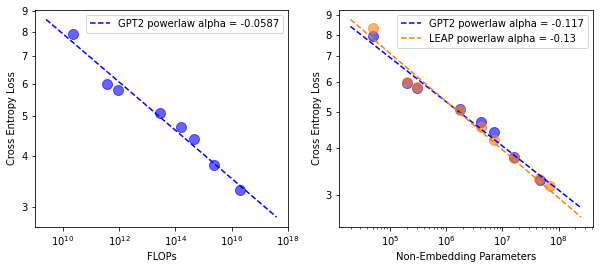

In [ ]:
def powerlaw(n, n_c, a):
    return (n_c / n)**a



# for comptute
plt.subplot(1, 2, 1)
x = 10**np.arange(start = 9.4, stop = 17.7, step = .1, dtype = 'float64')
plt.loglog()
plt.yticks([3, 4, 5, 6, 7, 8, 9], labels = [3, 4, 5, 6, 7, 8, 9])

#plt.plot(gpt2_flos, gpt2_y, ".-", color = 'C0', label = "GPT2 linear interpolation", markersize = 10)
plt.scatter(x = gpt2_flos, y = gpt2_y, s = 100, alpha = .6, color = 'blue')
(n_c, a), _ = curve_fit(powerlaw, gpt2_flos, gpt2_y, maxfev=10000, p0 = np.array([9e30, .05]))
plt.plot(x, powerlaw(x, n_c, a), label = f'GPT2 powerlaw alpha = {-a:.3}', linestyle = '--', color = 'blue')
print("GPT2", n_c, a)


plt.xlabel("FLOPs")
plt.ylabel("Cross Entropy Loss")
plt.legend()



# for parameters
plt.subplot(1, 2, 2)
x = 10**np.arange(start = 4.3, stop = 8.5, step = .1, dtype = 'float64')
plt.loglog()
plt.yticks([2, 3, 4, 5, 6, 7, 8, 9], labels = [2, 3, 4, 5, 6, 7, 8, 9])

plt.scatter(x = gpt2_param, y = gpt2_y, s = 100, alpha = .6, color = 'blue')
(n_c, a), _ = curve_fit(powerlaw, gpt2_param, gpt2_y, maxfev=10000, p0 = np.array([9e13, .076]))
plt.plot(x, powerlaw(x, n_c, a), label = f'GPT2 powerlaw alpha = {-a:.3}', linestyle = '--', color = 'blue')
print("GPT2", n_c, a)

plt.scatter(x = leap_param, y = leap_y, s = 100, alpha = .6, color = 'C1')
(n_c, a), _ = curve_fit(powerlaw, leap_param, leap_y, maxfev=10000, p0 = np.array([9e13, .076]))
plt.plot(x, powerlaw(x, n_c, a), label = f'LEAP powerlaw alpha = {-a:.2}', linestyle = '--', color = 'C1')
print("LEAP", n_c, a)

plt.xlabel("Non-Embedding Parameters")
plt.ylabel("Cross Entropy Loss")
plt.legend()


plt.savefig('powerlaws.png', dpi = 150)
plt.show()

# APPENDIX

In [ ]:
import re

# to count tokens, comes from https://huggingface.co/docs/tokenizers/components
whitespace_regex = re.compile("\w+|[^\w\s]+")

# get number of tokens
total_tokens = 0
for row in raw_datasets["train"]["text"]:
    total_tokens += len((whitespace_regex.split(row)))
total_tokens

105268829

# LSTM TRAINING

In [ ]:
run_training(hidden_size = 64, rnn = True)

Using 1 layers
NON EMBEDDING PARAMETERS: 33408, with commas 33,408


C:\Users\micha\anaconda3\lib\site-packages\torch\nn\init.py:403: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
C:\Users\micha\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


NUMBER OF TOKENS: 369664, with commas 369,664


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss



===============TOTAL TRAINING FLOATING POINT OPERATIONS===============

Numeric form: 74098409472
Human Readable: 74,098,409,472

===============TEST SET CROSS ENTROPY LOSS EVALUATION===============



{'eval_loss': 15.131314277648926, 'eval_runtime': 3.2103, 'eval_samples_per_second': 74.137, 'eval_steps_per_second': 37.068, 'epoch': 1.0}


In [ ]:
run_training(hidden_size = 96, rnn = True)

Using 1 layers
NON EMBEDDING PARAMETERS: 74688, with commas 74,688
NUMBER OF TOKENS: 670720, with commas 670,720


Step,Training Loss,Validation Loss



===============TOTAL TRAINING FLOATING POINT OPERATIONS===============

Numeric form: 300568412160
Human Readable: 300,568,412,160

===============TEST SET CROSS ENTROPY LOSS EVALUATION===============



{'eval_loss': 10.494235038757324, 'eval_runtime': 3.5429, 'eval_samples_per_second': 67.177, 'eval_steps_per_second': 33.589, 'epoch': 1.0}


In [ ]:
run_training(hidden_size = 128, rnn = True)

Using 1 layers
NON EMBEDDING PARAMETERS: 132352, with commas 132,352
NUMBER OF TOKENS: 1024000, with commas 1,024,000


Step,Training Loss,Validation Loss
500,13.526600,8.492445



===============TOTAL TRAINING FLOATING POINT OPERATIONS===============

Numeric form: 813170688000
Human Readable: 813,170,688,000

===============TEST SET CROSS ENTROPY LOSS EVALUATION===============



{'eval_loss': 8.3527250289917, 'eval_runtime': 3.4871, 'eval_samples_per_second': 68.252, 'eval_steps_per_second': 34.126, 'epoch': 1.0}


In [ ]:
run_training(hidden_size = 160, rnn = True)

Using 1 layers
NON EMBEDDING PARAMETERS: 206400, with commas 206,400


C:\Users\micha\anaconda3\lib\site-packages\torch\nn\init.py:403: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
C:\Users\micha\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


NUMBER OF TOKENS: 1423360, with commas 1,423,360


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
500,13.012000,7.334210



===============TOTAL TRAINING FLOATING POINT OPERATIONS===============

Numeric form: 1762689024000
Human Readable: 1,762,689,024,000

===============TEST SET CROSS ENTROPY LOSS EVALUATION===============



{'eval_loss': 7.193444728851318, 'eval_runtime': 3.7914, 'eval_samples_per_second': 62.774, 'eval_steps_per_second': 31.387, 'epoch': 1.0}


In [ ]:
run_training(hidden_size = 192, rnn = True)

Using 4 layers
NON EMBEDDING PARAMETERS: 1186176, with commas 1,186,176


C:\Users\micha\anaconda3\lib\site-packages\torch\nn\init.py:403: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


NUMBER OF TOKENS: 5188608, with commas 5,188,608


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
500,14.231200,6.937136
1000,6.190400,5.915351
1500,5.678500,5.660433
2000,5.502000,5.531826
2500,5.436800,5.505051



===============TOTAL TRAINING FLOATING POINT OPERATIONS===============

Numeric form: 36927613698048
Human Readable: 36,927,613,698,048

===============TEST SET CROSS ENTROPY LOSS EVALUATION===============



{'eval_loss': 5.423725605010986, 'eval_runtime': 12.5413, 'eval_samples_per_second': 18.977, 'eval_steps_per_second': 9.489, 'epoch': 1.0}


In [ ]:
run_training(hidden_size = 224, rnn = True)

In [ ]:
run_training(hidden_size = 256, rnn = True)

In [ ]:
run_training(hidden_size = 320, rnn = True)

In [ ]:
run_training(hidden_size = 448, rnn = True)